# Building MLP Part 1
- Video: [Andrej Karpathy - Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I&t=4076s)
- MLP paper: [Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


In [1]:
# core libraries
import torch
import torch.nn.functional as F

import numpy as np
import pandas as pd
import pyarrow as pa
import random
import seaborn as sns
import matplotlib.pyplot as plt

# matpolitlib config
%matplotlib inline

In [2]:
words = open('./source/names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [6]:
# initial parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
emb = C[X] # (32, 3, 2)

# view figures 3 * 2 = 6 and -1 is whats left (32)
# tanh gives us are values between 0 and 1
h = torch.tanh(emb.view(-1, 6)) @ W1 + b1 # (32, 100)

# logits
logits = h @ W2 + b2 # (32, 27)

# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

# mean negative log liklihood loss
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(43.8587)

In [8]:
# more efficient using cross_entropy

emb = C[X] # (32, 3, 2)

# view figures 3 * 2 = 6 and -1 is whats left (32)
# tanh gives us are values between 0 and 1
h = torch.tanh(emb.view(-1, 6)) @ W1 + b1 # (32, 100)

# logits
logits = h @ W2 + b2 # (32, 27)

# Best practice in Torch removing softmax and log loss liklihood
loss = F.cross_entropy(logits, Y)
loss

tensor(43.8587)

## Full neural network

### character encoder decoder

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### Build the dataset

In [10]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

### Parameters initialisation

In [12]:
# initial parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [13]:
# must be set in Torch
for p in parameters:
    p.requires_grad = True

### Optimize Neural Network

#### forward pass

In [14]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6)) @ W1 + b1
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

#### backward pass

In [15]:
# set the parameter gradients to 0
for p in parameters:
    p.grad = None # same as setting to 0 but more efficient
# populate those gradients
loss.backward()

#### update

In [16]:
# take the parameter data and nudge the gradient by the learning rate
for p in parameters:
    p.data += -0.1 * p.grad


### Improve Optimization with loop and batch

In [17]:
# initial parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [18]:
# must be set in Torch
for p in parameters:
    p.requires_grad = True

In [19]:
for _ in range(10):

    # autobatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6)) @ W1 + b1
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward
    for p in parameters:
        p.grad = None 
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss)

tensor(14.3826, grad_fn=<NllLossBackward0>)


### Check progress without batch for acuracy

In [20]:
emb = C[X[ix]]
h = torch.tanh(emb.view(-1, 6)) @ W1 + b1
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y[ix])
loss


tensor(10.4499, grad_fn=<NllLossBackward0>)

### Optimize the Learning rate
even spaced steps are no good so steps need to be exponents.
Line space of -3 to 0 gives the exponent of 0 to 1

In [21]:
# initial parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [22]:
# must be set in Torch
for p in parameters:
    p.requires_grad = True

In [23]:
# learning rate exponent
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [24]:
lri = []
lossi = []
stepi = []

In [25]:
for i in range(1000):

    # autobatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6)) @ W1 + b1
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward
    for p in parameters:
        p.grad = None 
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lr) # save the learning rate
    lri.append(lre[i]) # save the learning rate exponent
    lossi.append(loss.item())



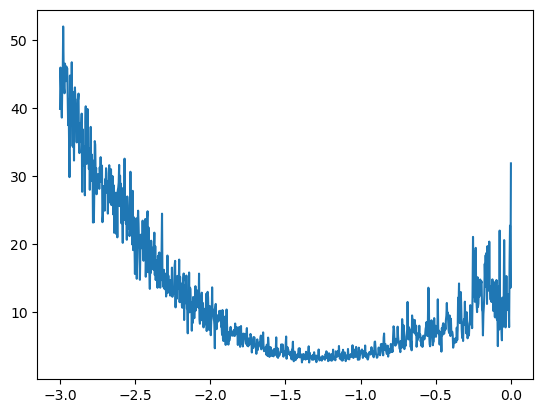

In [26]:
plt.plot(lri, lossi)

set the learning rate to the value of the exponent of -1 ($10^{-1}$)

Then finish on a learning rate decay which is generally $ 10^x $ lower. In our case 0.01

## Results